# 📊 03. PRODUCTION AGGREGATION

## 🎯 MỤC TIÊU:
- Hiểu cách aggregate từ STAGING → PRODUCTION
- Tạo business metrics
- Optimize cho reporting

## 📚 NỘI DUNG:
1. Daily Sales Aggregation
2. Monthly Sales Summary
3. Category Metrics
4. Product Metrics
5. Customer Lifetime Value

In [1]:
import sys
sys.path.append('../scripts')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from db_connector import DatabaseConnector
from etl_prod import ProdLayerETL

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported!")

✅ Libraries imported!


## 1. DAILY SALES AGGREGATION

In [2]:
print("📊 DAILY SALES AGGREGATION")
print("="*70)

db = DatabaseConnector()

# Query to build daily sales
daily_sales_query = """
SELECT 
    o.order_date,
    COUNT(DISTINCT o.order_id) as total_orders,
    SUM(oi.quantity) as total_items,
    SUM(oi.quantity * oi.unit_price * (1 - oi.discount_percent/100)) as total_revenue,
    COUNT(DISTINCT o.customer_id) as total_customers
FROM staging.orders o
JOIN staging.order_items oi ON o.order_id = oi.order_id
WHERE o.order_status = 'completed'
GROUP BY o.order_date
ORDER BY o.order_date
LIMIT 10
"""

daily_sales = db.read_sql(daily_sales_query)
daily_sales['avg_order_value'] = (daily_sales['total_revenue'] / daily_sales['total_orders']).round(2)

print(f"\n✅ Generated daily sales for {len(daily_sales)} days")
display(daily_sales)

2025-12-20 09:28:21,158 - db_connector - INFO - Database connector initialized for data_engineer@postgres
2025-12-20 09:28:21,191 - db_connector - INFO - Query executed, DataFrame shape: (10, 5)


📊 DAILY SALES AGGREGATION

✅ Generated daily sales for 10 days


,order_date,total_orders,total_items,total_revenue,total_customers,avg_order_value
0,2025-01-02,119,1086,4.772487e+05,54,4010.49
1,2025-01-03,308,2865,1.224600e+06,99,3975.97
2,2025-01-04,127,1118,4.782745e+05,79,3765.94
3,2025-01-05,161,1453,6.031785e+05,95,3746.45
4,2025-01-06,224,2003,8.302119e+05,133,3706.30
5,2025-01-07,238,2143,9.475760e+05,157,3981.41
6,2025-01-08,282,2607,1.104532e+06,174,3916.78
7,2025-01-09,194,1738,7.590865e+05,131,3912.82
8,2025-01-10,93,821,3.667340e+05,75,3943.38
9,2025-01-11,261,2261,9.526259e+05,174,3649.91


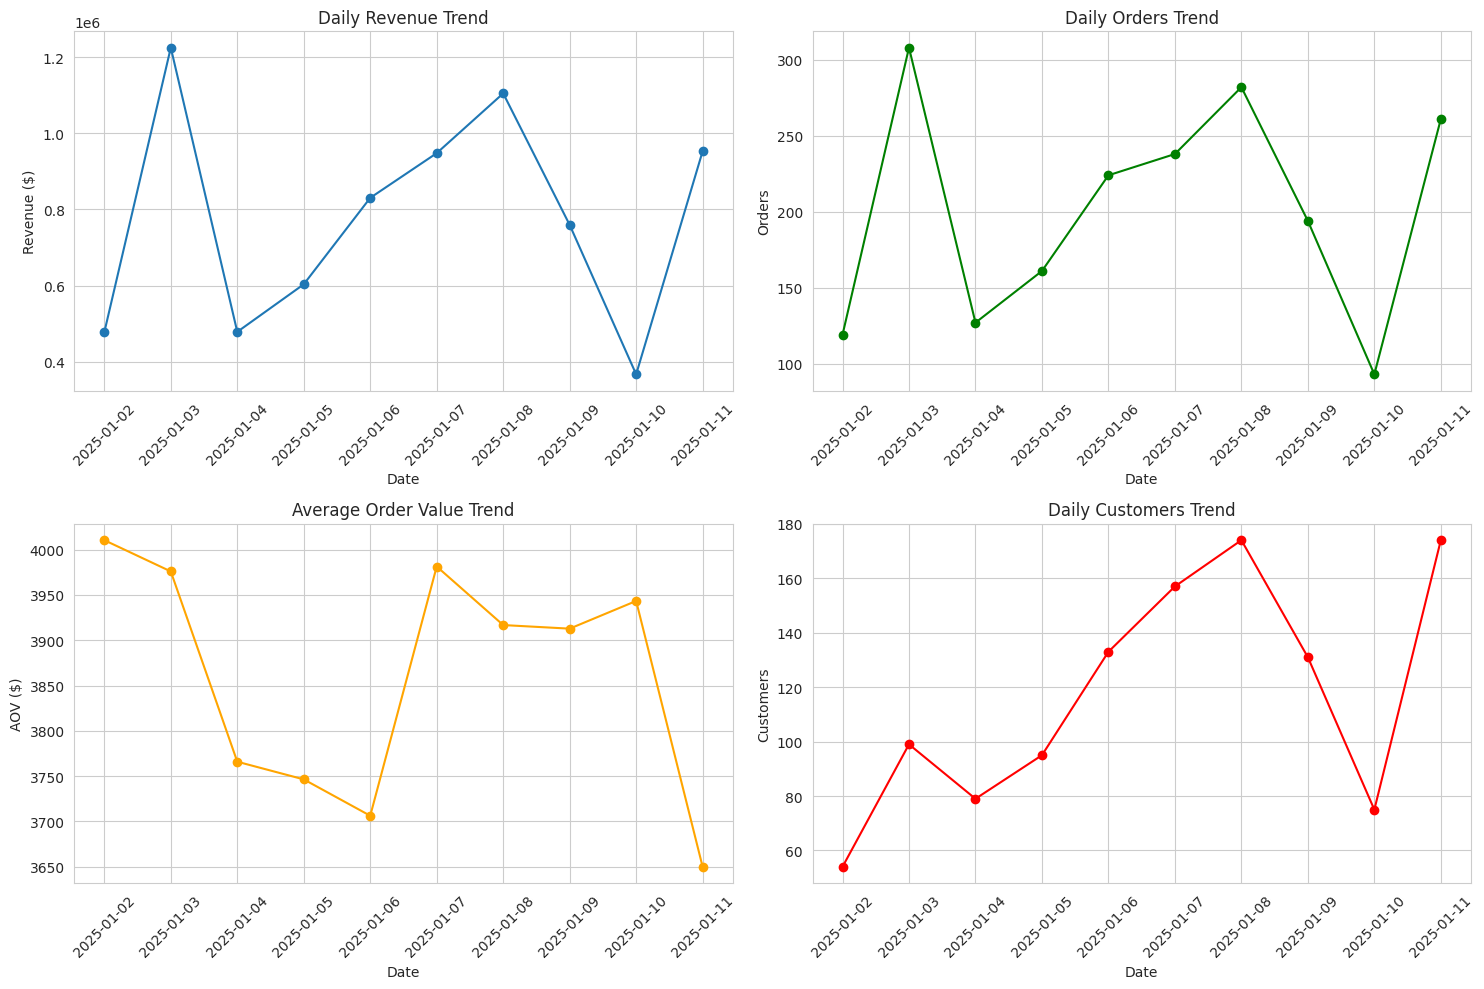

In [3]:
# Visualize daily sales
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Revenue trend
axes[0, 0].plot(daily_sales['order_date'], daily_sales['total_revenue'], marker='o')
axes[0, 0].set_title('Daily Revenue Trend')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Revenue ($)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Orders trend
axes[0, 1].plot(daily_sales['order_date'], daily_sales['total_orders'], marker='o', color='green')
axes[0, 1].set_title('Daily Orders Trend')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Orders')
axes[0, 1].tick_params(axis='x', rotation=45)

# Average order value
axes[1, 0].plot(daily_sales['order_date'], daily_sales['avg_order_value'], marker='o', color='orange')
axes[1, 0].set_title('Average Order Value Trend')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('AOV ($)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Customers trend
axes[1, 1].plot(daily_sales['order_date'], daily_sales['total_customers'], marker='o', color='red')
axes[1, 1].set_title('Daily Customers Trend')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Customers')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 2. MONTHLY SALES SUMMARY

In [4]:
print("📊 MONTHLY SALES SUMMARY")
print("="*70)

monthly_sales_query = """
SELECT 
    TO_CHAR(o.order_date, 'YYYY-MM') as year_month,
    EXTRACT(YEAR FROM o.order_date)::INTEGER as year,
    EXTRACT(MONTH FROM o.order_date)::INTEGER as month,
    COUNT(DISTINCT o.order_id) as total_orders,
    SUM(oi.quantity) as total_items,
    SUM(oi.quantity * oi.unit_price * (1 - oi.discount_percent/100)) as total_revenue,
    COUNT(DISTINCT o.customer_id) as total_customers
FROM staging.orders o
JOIN staging.order_items oi ON o.order_id = oi.order_id
WHERE o.order_status = 'completed'
GROUP BY year_month, year, month
ORDER BY year_month
"""

monthly_sales = db.read_sql(monthly_sales_query)
monthly_sales['avg_order_value'] = (monthly_sales['total_revenue'] / monthly_sales['total_orders']).round(2)

print(f"\n✅ Generated monthly sales for {len(monthly_sales)} months")
display(monthly_sales.head(10))

📊 MONTHLY SALES SUMMARY


2025-12-20 09:30:13,271 - db_connector - INFO - Query executed, DataFrame shape: (12, 7)



✅ Generated monthly sales for 12 months


,year_month,year,month,total_orders,total_items,total_revenue,total_customers,avg_order_value
0,2025-01,2025,1,6546,59355,2.510021e+07,812,3834.43
1,2025-02,2025,2,6212,56586,2.367457e+07,1496,3811.10
2,2025-03,2025,3,6041,55033,2.297435e+07,2153,3803.07
3,2025-04,2025,4,6656,59613,2.496125e+07,2844,3750.19
4,2025-05,2025,5,6916,62162,2.615130e+07,3378,3781.27
5,2025-06,2025,6,5465,48914,2.028438e+07,3317,3711.69
6,2025-07,2025,7,7004,63071,2.659628e+07,4092,3797.30
7,2025-08,2025,8,5455,48909,2.045543e+07,3733,3749.85
8,2025-09,2025,9,6965,63100,2.649491e+07,4523,3804.01
9,2025-10,2025,10,6808,60890,2.556029e+07,4665,3754.45


2025-12-20 09:30:13,555 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-20 09:30:13,559 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-20 09:30:13,578 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-20 09:30:13,580 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


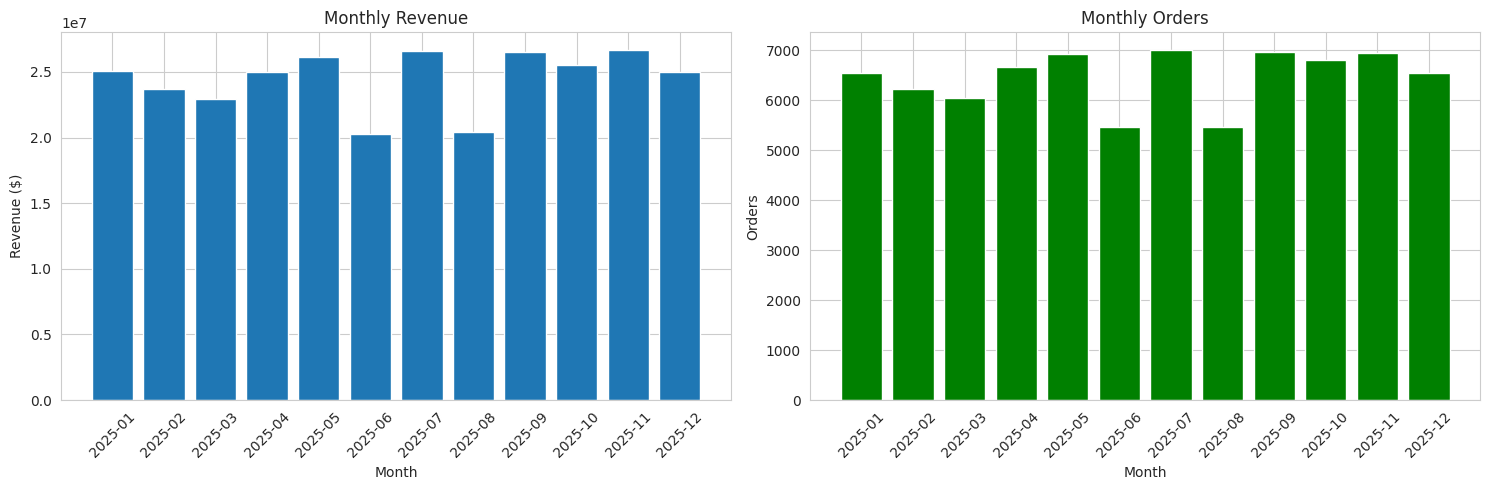

In [5]:
# Visualize monthly sales
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Monthly revenue
axes[0].bar(monthly_sales['year_month'], monthly_sales['total_revenue'])
axes[0].set_title('Monthly Revenue')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Revenue ($)')
axes[0].tick_params(axis='x', rotation=45)

# Monthly orders
axes[1].bar(monthly_sales['year_month'], monthly_sales['total_orders'], color='green')
axes[1].set_title('Monthly Orders')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Orders')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. CATEGORY METRICS

In [6]:
print("📊 CATEGORY METRICS")
print("="*70)

category_query = """
SELECT 
    p.category,
    COUNT(DISTINCT o.order_id) as total_orders,
    SUM(oi.quantity) as total_items,
    SUM(oi.quantity * oi.unit_price * (1 - oi.discount_percent/100)) as total_revenue,
    COUNT(DISTINCT o.customer_id) as unique_customers,
    COUNT(DISTINCT p.product_id) as unique_products
FROM staging.orders o
JOIN staging.order_items oi ON o.order_id = oi.order_id
JOIN staging.products p ON oi.product_id = p.product_id
WHERE o.order_status = 'completed'
GROUP BY p.category
ORDER BY total_revenue DESC
"""

category_metrics = db.read_sql(category_query)
category_metrics['total_revenue'] = category_metrics['total_revenue'].round(2)

print(f"\n✅ Generated metrics for {len(category_metrics)} categories")
display(category_metrics)

📊 CATEGORY METRICS


2025-12-20 09:30:14,724 - db_connector - INFO - Query executed, DataFrame shape: (7, 6)



✅ Generated metrics for 7 categories


,category,total_orders,total_items,total_revenue,unique_customers,unique_products
0,Electronics,37325,146478,66200428.18,8293,21
1,Home,34480,131664,51824647.82,8134,19
2,Clothing,25528,90845,41728361.51,7541,13
3,Sports,27174,98734,37776215.18,7652,14
4,Books,27253,98085,37711151.26,7700,14
5,Toys,18687,63939,29410999.92,6769,9
6,Food,20565,70183,29307482.56,6977,10


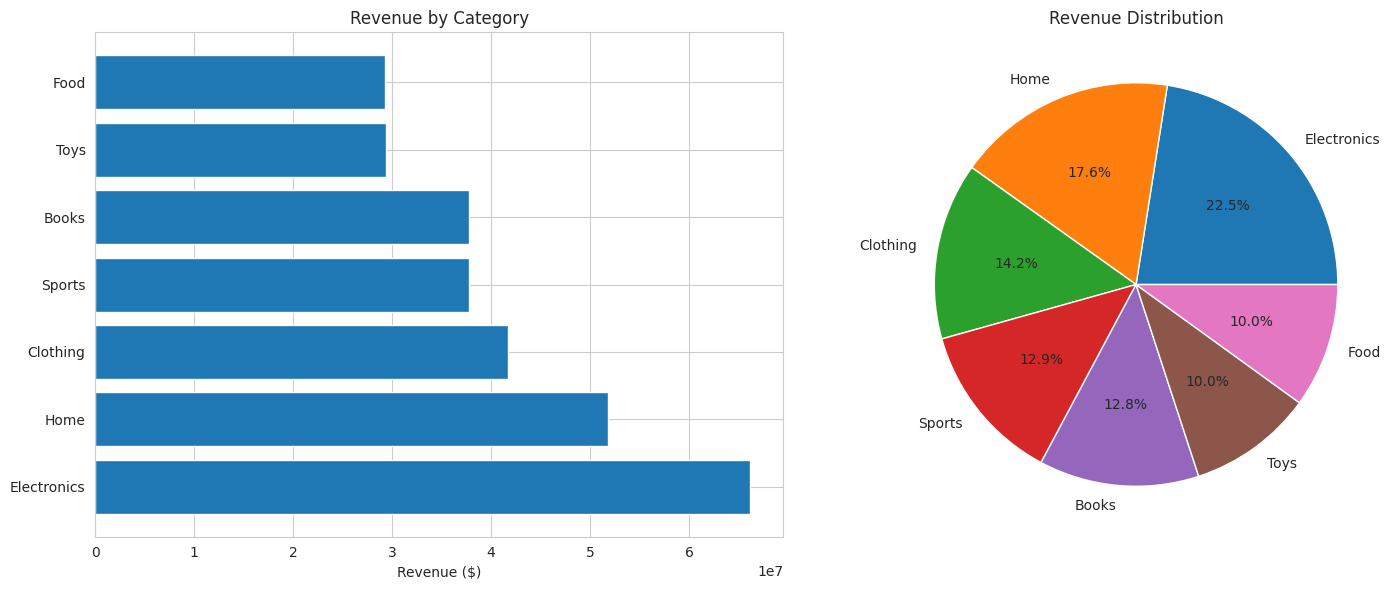

In [7]:
# Visualize category performance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Revenue by category
axes[0].barh(category_metrics['category'], category_metrics['total_revenue'])
axes[0].set_title('Revenue by Category')
axes[0].set_xlabel('Revenue ($)')

# Revenue pie chart
axes[1].pie(category_metrics['total_revenue'], labels=category_metrics['category'], autopct='%1.1f%%')
axes[1].set_title('Revenue Distribution')

plt.tight_layout()
plt.show()

## 4. TOP PRODUCTS

In [8]:
print("📊 TOP PRODUCTS")
print("="*70)

top_products_query = """
SELECT 
    p.product_id,
    p.product_name,
    p.category,
    COUNT(DISTINCT o.order_id) as total_orders,
    SUM(oi.quantity) as total_quantity,
    SUM(oi.quantity * oi.unit_price * (1 - oi.discount_percent/100)) as total_revenue
FROM staging.orders o
JOIN staging.order_items oi ON o.order_id = oi.order_id
JOIN staging.products p ON oi.product_id = p.product_id
WHERE o.order_status = 'completed'
GROUP BY p.product_id, p.product_name, p.category
ORDER BY total_revenue DESC
LIMIT 10
"""

top_products = db.read_sql(top_products_query)
top_products['total_revenue'] = top_products['total_revenue'].round(2)

print(f"\n✅ Top 10 Products by Revenue")
display(top_products)

📊 TOP PRODUCTS


2025-12-20 09:30:15,465 - db_connector - INFO - Query executed, DataFrame shape: (10, 6)



✅ Top 10 Products by Revenue


,product_id,product_name,category,total_orders,total_quantity,total_revenue
0,40,Intuitive Impactful Flexibility,Electronics,2343,6992,7143089.84
1,79,Robust Interactive Data-warehouse,Toys,2342,7166,6678231.57
2,53,Synergized Interactive Policy,Electronics,2259,6800,6570586.91
3,58,Synergized National System Engine,Sports,2340,7002,6468318.78
4,18,Cross-platform Heuristic Hardware,Toys,2381,7394,6421051.58
5,25,Cloned 6thgeneration Protocol,Home,2258,6934,6383241.62
6,85,Fully-configurable Directional Architecture,Sports,2302,7043,6211205.59
7,87,Reactive Discrete Parallelism,Home,2246,6819,5952988.02
8,50,Profound Modular Array,Books,2304,7001,5850133.26
9,31,Synchronized Encompassing Standardization,Clothing,2296,6975,5752281.46


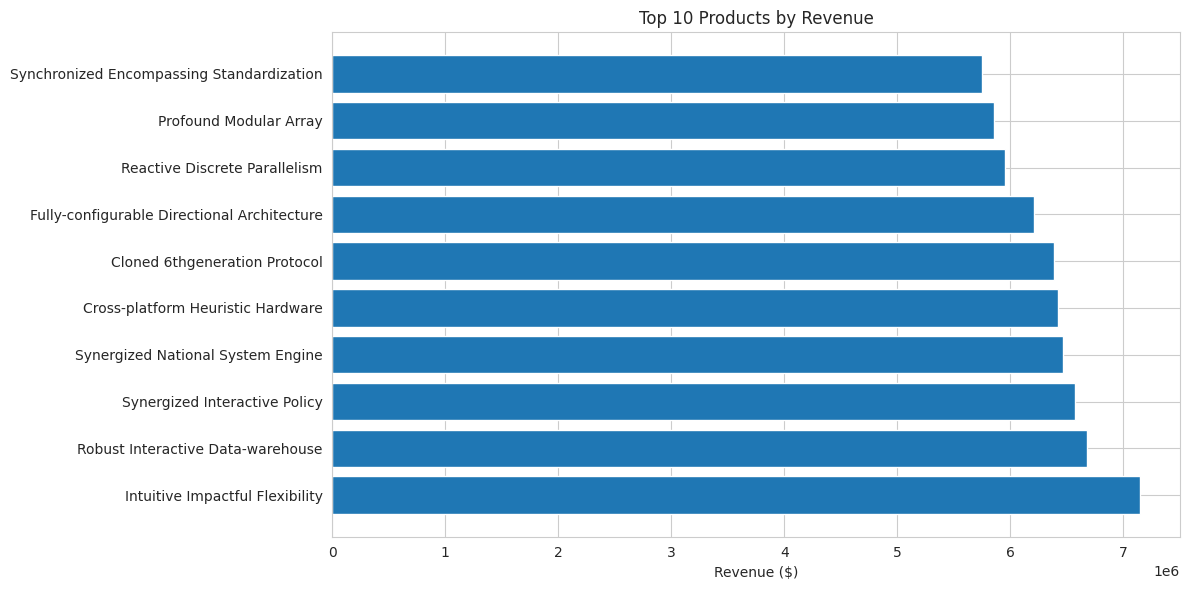

In [9]:
# Visualize top products
plt.figure(figsize=(12, 6))
plt.barh(top_products['product_name'], top_products['total_revenue'])
plt.xlabel('Revenue ($)')
plt.title('Top 10 Products by Revenue')
plt.tight_layout()
plt.show()

## 5. CUSTOMER LIFETIME VALUE

In [10]:
print("📊 CUSTOMER LIFETIME VALUE")
print("="*70)

clv_query = """
SELECT 
    c.customer_id,
    c.customer_name,
    c.customer_segment,
    MIN(o.order_date) as first_order_date,
    MAX(o.order_date) as last_order_date,
    COUNT(DISTINCT o.order_id) as total_orders,
    COALESCE(SUM(oi.quantity), 0) as total_items,
    COALESCE(SUM(oi.quantity * oi.unit_price * (1 - oi.discount_percent/100)), 0) as total_revenue
FROM staging.customers c
LEFT JOIN staging.orders o ON c.customer_id = o.customer_id AND o.order_status = 'completed'
LEFT JOIN staging.order_items oi ON o.order_id = oi.order_id
GROUP BY c.customer_id, c.customer_name, c.customer_segment
HAVING COUNT(DISTINCT o.order_id) > 0
ORDER BY total_revenue DESC
LIMIT 10
"""

clv = db.read_sql(clv_query)
clv['total_revenue'] = clv['total_revenue'].round(2)
clv['avg_order_value'] = (clv['total_revenue'] / clv['total_orders']).round(2)

print(f"\n✅ Top 10 Customers by Lifetime Value")
display(clv)

📊 CUSTOMER LIFETIME VALUE


2025-12-20 09:30:16,223 - db_connector - INFO - Query executed, DataFrame shape: (10, 8)



✅ Top 10 Customers by Lifetime Value


,customer_id,customer_name,customer_segment,first_order_date,last_order_date,total_orders,total_items,total_revenue,avg_order_value
0,27,Belinda Mccullough,Premium,2025-01-02,2025-12-13,51,469,211259.92,4142.35
1,205,James Gilbert,Premium,2025-01-06,2025-12-30,45,458,202498.59,4499.97
2,13,Michelle Harris,Standard,2025-01-03,2025-12-29,43,461,201554.25,4687.31
3,76,Sydney White,Basic,2025-01-03,2025-12-30,45,472,198595.12,4413.22
4,65,Kenneth Parks Jr.,Premium,2025-01-02,2025-12-31,46,448,189273.00,4114.63
5,48,Lawrence Adkins,Standard,2025-01-02,2025-11-26,43,431,185821.11,4321.42
6,52,Ashley Yu,Standard,2025-01-02,2025-10-02,45,428,185459.72,4121.33
7,112,Claudia Wallace,Premium,2025-01-03,2025-12-26,40,415,183259.70,4581.49
8,17,Rebecca Valencia,Basic,2025-01-02,2025-10-05,41,385,181647.21,4430.42
9,121,Dr. Jessica Rodriguez Dds,Premium,2025-01-06,2025-12-23,50,442,181169.30,3623.39


In [11]:
# Customer segment analysis
segment_query = """
SELECT 
    c.customer_segment,
    COUNT(DISTINCT c.customer_id) as total_customers,
    AVG(COALESCE(order_count, 0)) as avg_orders,
    AVG(COALESCE(total_revenue, 0)) as avg_revenue
FROM staging.customers c
LEFT JOIN (
    SELECT 
        customer_id,
        COUNT(*) as order_count,
        SUM(total_amount) as total_revenue
    FROM staging.orders
    WHERE order_status = 'completed'
    GROUP BY customer_id
) o ON c.customer_id = o.customer_id
GROUP BY c.customer_segment
"""

segment_analysis = db.read_sql(segment_query)
display(segment_analysis)

2025-12-20 09:30:16,327 - db_connector - INFO - Query executed, DataFrame shape: (3, 4)


,customer_segment,total_customers,avg_orders,avg_revenue
0,Basic,3541,7.162101,27057.741870
1,Premium,3546,7.246757,27484.712408
2,Standard,3593,7.375452,28023.109758


## 6. RUN FULL PRODUCTION ETL

In [12]:
print("🚀 RUN FULL PRODUCTION ETL")
print("="*70)

etl_prod = ProdLayerETL(db)

# Run all production aggregations
results = etl_prod.build_all()

print(f"\n✅ Production ETL Complete!")
for table, result in results.items():
    print(f"\n{table}:")
    print(f"  Rows created: {result['rows']:,}")

2025-12-20 09:30:16,502 - etl_prod - INFO - ============================================================
2025-12-20 09:30:16,504 - etl_prod - INFO - ETL PRODUCTION LAYER - STARTING
2025-12-20 09:30:16,505 - etl_prod - INFO - ============================================================
2025-12-20 09:30:16,506 - etl_prod - INFO - Building daily_sales...


🚀 RUN FULL PRODUCTION ETL


2025-12-20 09:30:16,854 - db_connector - INFO - Query executed, DataFrame shape: (364, 5)
2025-12-20 09:30:16,873 - db_connector - INFO - Query executed successfully
2025-12-20 09:30:16,875 - db_connector - INFO - Truncated: prod.daily_sales
2025-12-20 09:30:16,928 - db_connector - INFO - Written 364 rows to prod.daily_sales
2025-12-20 09:30:16,928 - etl_prod - INFO - Daily Sales: 364 days aggregated
2025-12-20 09:30:16,929 - etl_prod - INFO - Building monthly_sales...
2025-12-20 09:30:17,471 - db_connector - INFO - Query executed, DataFrame shape: (12, 7)
2025-12-20 09:30:17,482 - db_connector - INFO - Query executed successfully
2025-12-20 09:30:17,483 - db_connector - INFO - Truncated: prod.monthly_sales
2025-12-20 09:30:17,494 - db_connector - INFO - Written 12 rows to prod.monthly_sales
2025-12-20 09:30:17,495 - etl_prod - INFO - Monthly Sales: 12 months aggregated
2025-12-20 09:30:17,496 - etl_prod - INFO - Building daily_category_metrics...
2025-12-20 09:30:17,938 - db_connector


✅ Production ETL Complete!

daily_sales:
  Rows created: 364

monthly_sales:
  Rows created: 12

daily_category_metrics:
  Rows created: 2,548

daily_product_metrics:
  Rows created: 35,837

customer_metrics:
  Rows created: 10,680


## 7. VERIFY PRODUCTION TABLES

In [13]:
print("🔍 VERIFY PRODUCTION TABLES")
print("="*70)

# Check all prod tables
prod_tables = [
    'daily_sales',
    'monthly_sales',
    'daily_category_metrics',
    'daily_product_metrics',
    'customer_metrics'
]

for table in prod_tables:
    count_query = f"SELECT COUNT(*) as count FROM prod.{table}"
    count = db.read_sql(count_query)['count'][0]
    print(f"  {table:.<35} {count:>10,} rows")

2025-12-20 09:30:22,137 - db_connector - INFO - Query executed, DataFrame shape: (1, 1)
2025-12-20 09:30:22,141 - db_connector - INFO - Query executed, DataFrame shape: (1, 1)
2025-12-20 09:30:22,145 - db_connector - INFO - Query executed, DataFrame shape: (1, 1)
2025-12-20 09:30:22,153 - db_connector - INFO - Query executed, DataFrame shape: (1, 1)
2025-12-20 09:30:22,158 - db_connector - INFO - Query executed, DataFrame shape: (1, 1)


🔍 VERIFY PRODUCTION TABLES
  daily_sales........................        364 rows
  monthly_sales......................         12 rows
  daily_category_metrics.............      2,548 rows
  daily_product_metrics..............     35,837 rows
  customer_metrics...................     10,680 rows


In [14]:
# Sample from prod.daily_sales
print("\n📊 Sample: prod.daily_sales")
sample_query = "SELECT * FROM prod.daily_sales ORDER BY order_date LIMIT 5"
display(db.read_sql(sample_query))

2025-12-20 09:30:22,173 - db_connector - INFO - Query executed, DataFrame shape: (5, 8)



📊 Sample: prod.daily_sales


,order_date,total_orders,total_items,total_revenue,total_customers,avg_order_value,created_at,updated_at
0,2025-01-02,119,1086,477248.72,54,4010.49,2025-12-20 09:30:16.858421,2025-12-20 09:30:16.860674
1,2025-01-03,308,2865,1224599.64,99,3975.97,2025-12-20 09:30:16.858421,2025-12-20 09:30:16.860674
2,2025-01-04,127,1118,478274.46,79,3765.94,2025-12-20 09:30:16.858421,2025-12-20 09:30:16.860674
3,2025-01-05,161,1453,603178.53,95,3746.45,2025-12-20 09:30:16.858421,2025-12-20 09:30:16.860674
4,2025-01-06,224,2003,830211.90,133,3706.30,2025-12-20 09:30:16.858421,2025-12-20 09:30:16.860674


In [15]:
# Sample from prod.customer_metrics
print("\n📊 Sample: prod.customer_metrics")
sample_query = "SELECT * FROM prod.customer_metrics ORDER BY total_revenue DESC LIMIT 5"
display(db.read_sql(sample_query))

2025-12-20 09:30:22,201 - db_connector - INFO - Query executed, DataFrame shape: (5, 13)



📊 Sample: prod.customer_metrics


,customer_id,customer_name,customer_segment,first_order_date,last_order_date,total_orders,total_items,total_revenue,avg_order_value,days_since_first_order,days_since_last_order,created_at,updated_at
0,27,Belinda Mccullough,Premium,2025-01-02,2025-12-13,51,469,211259.92,4142.35,352,7,2025-12-20 09:30:21.362767,2025-12-20 09:30:21.362987
1,205,James Gilbert,Premium,2025-01-06,2025-12-30,45,458,202498.59,4499.97,348,-10,2025-12-20 09:30:21.362767,2025-12-20 09:30:21.362987
2,13,Michelle Harris,Standard,2025-01-03,2025-12-29,43,461,201554.25,4687.31,351,-9,2025-12-20 09:30:21.362767,2025-12-20 09:30:21.362987
3,76,Sydney White,Basic,2025-01-03,2025-12-30,45,472,198595.12,4413.22,351,-10,2025-12-20 09:30:21.362767,2025-12-20 09:30:21.362987
4,65,Kenneth Parks Jr.,Premium,2025-01-02,2025-12-31,46,448,189273.00,4114.63,352,-11,2025-12-20 09:30:21.362767,2025-12-20 09:30:21.362987


# 🎓 KEY TAKEAWAYS

## ✅ Production Layer Characteristics:
1. **Aggregated**: Pre-calculated metrics
2. **Denormalized**: Optimized for queries
3. **Business-Ready**: Easy to understand
4. **Fast Queries**: No complex joins needed

## 📊 Metrics Created:
- **Daily Sales**: Revenue, orders, customers per day
- **Monthly Sales**: Monthly aggregations
- **Category Metrics**: Performance by category
- **Product Metrics**: Top products, trends
- **Customer Metrics**: Lifetime value, segments

## 🔄 Next Step:
- Open `04_full_pipeline_demo.ipynb` để xem full pipeline flow

In [16]:
print("\n✅ Production Aggregation Complete!")


✅ Production Aggregation Complete!
